In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import cv2

In [5]:
# Not working for our case
# inspired from youtube https://www.youtube.com/watch?v=G92TF4xYQcU
# definitions from wikipedia https://en.wikipedia.org/wiki/Q-learning

In [6]:
 ### Description goal
# There are three designated locations in the grid world indicated by R(ed),
# G(reen), and B(lue). When the episode starts, the START is 
# at a random square and the EXIT is at a random square. The START path
# must pass by the TREASURE, from the TREASURE, the path leads to the EXIT. at the EXIT the episode ends. There are 4 obstacles called WALL.
# Map:
# S(tart), P(ath), T(reasure), W(all), E(xit)
# "4x4":["SPPW",
#        "PWPP",
#        "PTPW",
#        "PWPE"]

In [7]:
# 1 grid 4x4
# 1start 1treasure 1exit
# rewards: start, treasure, exit. 
# test 1: start, treasure:50, exit:100
# test 2: start, treasure:100, exit:50
# move: up, down, left, right

on # 0, epsilon:0.5
1000 ep mean nan
on # 1000, epsilon:0.4093571882215585
1000 ep mean 42.51
on # 2000, epsilon:0.33514661509732085
1000 ep mean 43.628
on # 3000, epsilon:0.27438935199642484
1000 ep mean 46.086
on # 4000, epsilon:0.2246465072223834
1000 ep mean 46.401
on # 5000, epsilon:0.1839213250806981
1000 ep mean 47.134
on # 6000, epsilon:0.1505790329780355
1000 ep mean 47.09
on # 7000, epsilon:0.12328121909001953
1000 ep mean 47.485
on # 8000, epsilon:0.10093210641443259
1000 ep mean 47.977
on # 9000, epsilon:0.0826345665661825
1000 ep mean 48.637
on # 10000, epsilon:0.06765410763887933
1000 ep mean 48.866
on # 11000, epsilon:0.055389390549380635
1000 ep mean 48.513
on # 12000, epsilon:0.04534809034520036
1000 ep mean 48.971
on # 13000, epsilon:0.03712713350985694
1000 ep mean 48.892
on # 14000, epsilon:0.030396517960642792
1000 ep mean 49.282
on # 15000, epsilon:0.02488606624818969
1000 ep mean 49.342
on # 16000, epsilon:0.02037458021050879
1000 ep mean 49.392
on # 17000, epsil

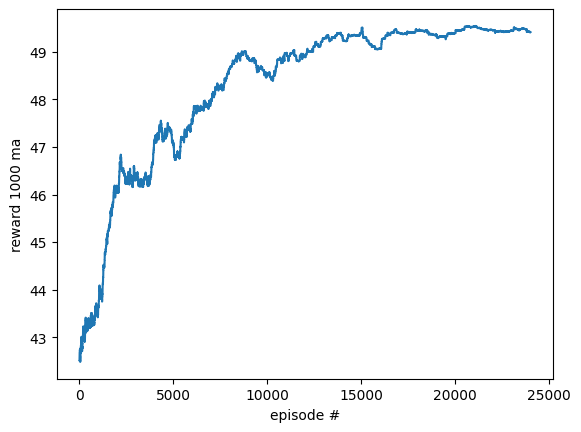

In [24]:
 # 4x4 grid start, treasure, exit will be initalize at random location at 4x4 grids
SIZE = 4 

# number of episodes
HM_EPISODES = 25000

# the penalties and rewards
MOVE_PENALTY = 1
TREASURE_REWARD = 50
EXIT_REWARD = 100
WALL_PENALTY = 50

# values between 0 and 1. The higher the epsilon, the more likely we are to perform a random action
# overtime, we want to stop our model to stop exploring
epsilon = 0.5

EPS_DECAY = 0.9998

# every 500 episodes we see what is happening
SHOW_EVERY = 1000

start_q_table = None #or filename


# The learning rate or step size determines to what extent newly acquired information overrides old information. 
#A factor of 0 makes the agent learn nothing (exclusively exploiting prior knowledge), while a factor of 1 makes the agent
#consider only the most recent information (ignoring prior knowledge to explore possibilities). In fully deterministic environments,
# a learning rate of alpha _{t}=1 is optimal. 
# When the problem is stochastic, the algorithm converges under some technical conditions on the learning rate 
# that require it to decrease to zero. In practice, often a constant learning rate is used, 
# such as alpha _{t}=0.1 for all t.
LEARNING_RATE = 0.1

# weight measure of how important do we find future actions vs current action or future reward over current reward. values between 0 and 1
DISCOUNT = 0.95 

PLAYER_N = 1 #green
TREASURE_N  = 2 #red
EXIT_N = 3 #blue
WALL_N = 4 # purple

d = {1: (255, 175, 0),   # bgr color
    2: (0, 255,0),
    3: (0,0,255),
    4: (221, 0, 255)}

class Blob:
    def __init__(self):
        self.x = 0 # x position of the blob
        self.y = 0 # y position of the blob
    def __add__(self, other):  # define other blob and strubstract it from the other blob
        return (self.x + other.x, self.y + other.y)
    # there are four actions up, down, left, right
    def action(self, choice): 
        if choice == 0: #up
            self.move(x=0, y=-1)
        elif choice == 1: #down
            self.move(x=0, y=1)
        elif choice == 2: #left
            self.move(x=-1, y=0)
        elif choice == 3: #right
            self.move(x=1, y=0)
    
    
    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x = np.random.randint(-1,2)
        else:
            self.x += x
        
        # If no value for y, move randomly
        if not y:
            self.y = np.random.randint(-1,2)
        else:
            self.y += y
        
        # If we are out of bounds, fix.
        if self.x <0:
            self.x = 0
        elif self.x > SIZE-1: # size 4 but positions 0 through 3
            self.x = SIZE-1
        if self.y <0:
            self.y = 0
        elif self.y > SIZE-1: 
            self.y = SIZE-1


# create the starting q-table with random values. It is a dictionnary
if start_q_table is None:
    q_table = {}
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
            for x2 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1, SIZE):
                    q_table[((x1,y1), (x2,y2))] = [np.random.uniform(-5,0) for i in range(4)]

# or load the q-table from a file
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

# empty list to put the rewards as a metric
episode_rewards= []


# iterate over episodes
for episode in range(HM_EPISODES):
    #create the player, exit and treasure
    # we consider that where the player stands (randomly) at the beginning is the start point
    player = Blob()
    treasure = Blob()
    exit = Blob()
    
    # if we can divide the episodes number by 500 and the remainder is 0
    if episode % SHOW_EVERY ==0:
        print(f"on # {episode}, epsilon:{epsilon}")
        print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
    episode_reward = 0
    for i in range(200):
        # initial discrete state
        obs = (player+treasure, player+exit)
        # np.random.random() creates a random float between 0 and 1
        if np.random.random()>epsilon:
        # do action in the normal way
            # maximum value of the discrete states where we should start
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0,4)
        
        # start the action
        player.action(action)
        #treasure.move()
        
        # take treasure reward
        if player.x == treasure.x and player.y == treasure.y:
            reward = TREASURE_REWARD
        # take exit reward
        elif player.x == exit.x and player.y == exit.y:
            reward = EXIT_REWARD      
       
        # put the 4 walls
        elif player.x == 0 and player.y == 3:
            reward = -WALL_PENALTY
        elif player.x == 1 and player.y == 1:
            reward = -WALL_PENALTY
        elif player.x == 2 and player.y == 3:
            reward = -WALL_PENALTY
        elif player.x == 3 and player.y == 1:
            reward = -WALL_PENALTY
        else:
            reward = -MOVE_PENALTY
        
        # new discrete state and new q-values
        new_obs = (player+treasure, player+exit)
        # maximum of the future q-value
        max_future_q = np.max(q_table[new_obs])
        #  curent q state and the action
        current_q = q_table[obs][action]
        if reward == EXIT_REWARD:
            new_q = EXIT_REWARD
        # take start reward
        elif reward == TREASURE_REWARD:
            new_q = TREASURE_REWARD
        elif reward == WALL_PENALTY:
            new_q = -WALL_PENALTY
        else:
            # The core of the algorithm is a Bellman equation 
            # as a simple value iteration update, using the weighted average of the current value and the new information
            new_q = (1-LEARNING_RATE) * current_q + LEARNING_RATE*(reward + DISCOUNT * max_future_q)
        # update the q-table with new q-values
        q_table[obs][action] = new_q
        
        #let's create the environment
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
            env[3][3] = d[EXIT_N]
            env[player.y][player.x] = d[PLAYER_N]
            env[2][1] = d[TREASURE_N]
            env[0][3] = d[WALL_N]
            env[1][1] = d[WALL_N]
            env[2][3] = d[WALL_N]
            env[3][1] = d[WALL_N]
            # create image from array
            img = Image.fromarray(env,"RGB")
            img = img.resize((300,300))
            cv2.imshow("", np.array(img))
            if reward == EXIT_REWARD or reward == TREASURE_REWARD:
                if cv2.waitKey(500) & 0xFF== ord("q"):
                    break
            else:
                if cv2.waitKey(1) & 0xFF== ord("q"):
                    break
        episode_reward += reward
        if reward == EXIT_REWARD or reward == TREASURE_REWARD:
            break
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

# accuracy and plot
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode="valid")
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"reward {SHOW_EVERY} ma")
plt.xlabel("episode #")
plt.show()

# with open(f"q_table-{int(time.time())}.pickle", "wb") as f:
#     pickle.dump(q_table,f)

In [ ]:
EXIT_N

In [ ]:
exit.x

In [ ]:
env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)

env[3][3] = d[EXIT_N]
env[player.y][player.x] = d[PLAYER_N]
env[2][1] = d[TREASURE_N]
env[0][3] = d[WALL_N]
env[1][1] = d[WALL_N]
env[2][3] = d[WALL_N]
env[3][1] = d[WALL_N]
env

# 4 lists representing 4 rows. 
# The second column of the first row contains a red spot.
# The second column of the third row contains a blue spot.

In [ ]:
img = Image.fromarray(env,"RGB")
img = img.resize((300,300))
img

In [ ]:
np.random.randint(-1,2)

In [ ]:
# create the starting q-table with random values. It is a dictionnary
if start_q_table is None:
    q_table = {}
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
            for x2 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1, SIZE):
                    q_table[((x1,y1), (x2,y2))] = [np.random.uniform(-5,0) for i in range(4)]

In [ ]:
print(q_table)